In [2]:
from quimb import *
from quimb.tensor import *
import quimb as qu
import numpy as np
import quimb.tensor as qtn
import matplotlib.pyplot as plt
from numpy import linalg as LA
import math
#pip install --no-deps -U -e .
import cotengra as ctg
%matplotlib inline

/opt/anaconda3/lib/python3.8/site-packages/cotengra/hyper.py:27: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "
/opt/anaconda3/lib/python3.8/site-packages/cotengra/hyper.py:43: UserWarning: Couldn't find `optuna`, `baytune (btb)`, `chocolate`, `nevergrad` or `skopt` so will use completely random sampling in place of hyper-optimization.
  warnings.warn("Couldn't find `optuna`, `baytune (btb)`, `chocolate`, "


In [3]:
n = 2
delta = np.einsum('ij,jl,jn->iln', np.eye(n,n), np.eye(n,n),np.eye(n,n))
print (delta.shape, delta)

(2, 2, 2) [[[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 1.]]]


In [4]:
psi = qtn.MPS_computational_state('0' * 3)
for t in psi:
     t.modify(left_inds=())

G = qu.rand_uni(4,dtype='float64')
psi.gate_(G, (0, 1), tags={'P'} )
psi.unitize_(method='mgs', allow_no_left_inds=True)
psi.reindex_({f'k{0}':'k'})

d1_ind =[ f'k{0}','k',f'l{0}']
d1 = qtn.Tensor(delta,d1_ind,tags='del')
tn=psi & d1
K = qu.rand_uni(4,dtype='float64')

tn.view_as_(
     qtn.tensor_1d.TensorNetwork1DVector,
     L=2,
     site_tag_id='I{}',
     site_ind_id='k{}'
 )
tn.gate_(K, ('0','2'), tags={'O'}, contract=False)
tn_h=tn.H
tn_h.reindex_({f"k{0}":f"b{0}"})
tn_f=(tn_h & tn)^all
print (tn_f.data)

[[0.33160152 0.21045133]
 [0.21045133 0.66839848]]


In [5]:
def density_operator(L):
    psi = qtn.MPS_computational_state('0' * (2*L+1)) # +1 is for the physical qubit
    
    for t in psi:
         t.modify(left_inds=())
    delta = np.einsum('ij,jl,jn->iln', np.eye(2,2), np.eye(2,2),np.eye(2,2))
    G = qu.rand_uni(4,dtype='float64')
    K = qu.rand_uni(4,dtype='float64')
    for i in range (L):
        psi.gate_(G, (0+2*i, 1+2*i), tags={'Prep'} )
        psi.unitize_(method='mgs', allow_no_left_inds=True)
        psi.reindex_({f'k{2*i}':f'd{2*i}'})
        
        d1_ind =[f'k{2*i}',f'd{2*i}',f'l{2*i}']
        d1 = qtn.Tensor(delta,d1_ind,tags='del')
        psi=psi & d1
        psi.view_as_(
             qtn.tensor_1d.TensorNetwork1DVector,
             L=2*L+1,
             site_tag_id='I{}',
             site_ind_id='k{}'
         )
    for i in range (L):    
        psi.gate_(K, (f'{2*i}',f'{2*L}'), tags={'SU4'}, contract=False)
    return psi

In [11]:
def energy_ising(tn):
    tn_h = tn.H
    H = MPO_ham_ising(L, j=jz, bx=bx)
    for i in range(L):
        tn_h.reindex_({f"k{2*i}":f"b{2*i}"})
    H = MPO_ham_ising(L, j=jz, bx=bx)
    for i in range(L,0,-1):
        H.reindex_({f"k{(i-1)}":f"k{2*(i-1)}"})
        H.reindex_({f"b{(i-1)}":f"b{2*(i-1)}"})
    return (tn&H&tn_h).contract()

def normal(psi):
    return (psi.H & psi)^all

def norm_f(psi):
    # method='qr' is the default but the gradient seems very unstable
    # 'mgs' is a manual modified gram-schmidt orthog routine
    return psi.unitize(method='mgs',allow_no_left_inds=True)


In [16]:
jz = -1
bx = 0.5
L = 10
tn = density_operator(L)
energy_ising(tn)

-0.22042284130116388

In [17]:
tnopt = TNOptimizer(
    tn,                        # the tensor network we want to optimize
    loss_fn = energy_ising,                     # the function we want to minimize
    norm_fn = norm_f,
    autodiff_backend='auto',   # use 'autograd' for non-compiled optimization
    optimizer='tnc',     # the optimization algorithm
    tags=['Prep','SU4']
)

v_opt = tnopt.optimize(1000,tol=1e-6,jac=True,hessp=True)

-3.036664724350 [best: -3.036667346954] : : 1001it [00:20, 49.79it/s]                         


In [18]:
H = MPO_ham_ising(10, j=jz, bx=bx)
dmrg = qtn.DMRG2(H, bond_dims=[10, 20, 60, 80, 100, 150], cutoffs=1e-11)
dmrg.solve(tol=1e-12, verbosity=0 )
print("DMRG=", dmrg.energy)

DMRG= -3.0953724998316456


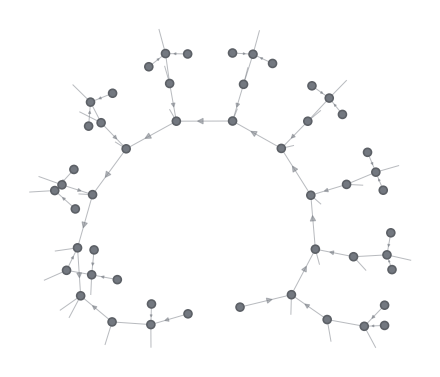

In [19]:
tn.draw()